# An initial training pipeline

In [ ]:
%load_ext dotenv
%dotenv 
import os
import sys
sys.path.append(os.getenv('SRC_DIR', '../../05_src'))
import dask.dataframe as dd
import pandas as pd
import numpy as np

from glob import glob
ft_dir = os.getenv("FEATURES_DATA", '../../05_src/data/features/stock_features')
ft_glob = glob(ft_dir+'/*.parquet')
df = dd.read_parquet(ft_glob).compute().reset_index().dropna()


The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [21]:
df

,ticker,Date,Open,High,Low,Close,Adj Close,Volume,source,Year,Close_lag_1
1,ACN,2017-01-04,116.910004,117.800003,116.430000,116.739998,110.576851,2639800.0,ACN.csv,2017,116.459999
2,ACN,2017-01-05,116.980003,117.139999,114.949997,114.989998,108.919258,3685400.0,ACN.csv,2017,116.739998
3,ACN,2017-01-06,114.989998,116.739998,114.339996,116.300003,110.160088,4125300.0,ACN.csv,2017,114.989998
4,ACN,2017-01-09,116.139999,116.349998,114.919998,115.000000,108.928719,2550800.0,ACN.csv,2017,116.300003
5,ACN,2017-01-10,114.940002,115.989998,114.639999,115.059998,108.985558,2550100.0,ACN.csv,2017,115.000000
...,...,...,...,...,...,...,...,...,...,...,...
343350,ZIXI,2004-06-28,8.440000,8.500000,7.660000,8.030000,8.030000,809200.0,ZIXI.csv,2004,8.660000
343351,ZIXI,2004-06-29,8.060000,8.060000,7.590000,7.650000,7.650000,467500.0,ZIXI.csv,2004,8.030000
343352,ZIXI,2004-06-30,7.640000,7.950000,7.550000,7.890000,7.890000,364000.0,ZIXI.csv,2004,7.650000
343353,ZIXI,2004-07-01,7.800000,7.950000,7.560000,7.700000,7.700000,189600.0,ZIXI.csv,2004,7.890000


In [22]:
cat_file = os.path.join(
    os.getenv("PRICE_CSV_DATA", '/data/prices_csv'), 
    'symbols_valid_meta.csv'
)
cat_df = (pd.read_csv(cat_file)
          .rename(columns = {'Symbol': 'ticker'})[['ticker', 'Listing Exchange', 'Market Category']]
          )
df = df.merge(cat_df, on = 'ticker', how = 'left')

## Preprocessing

+ Previously, we produced a features data set.
+ Most times, one or more [preprocessing steps](https://scikit-learn.org/stable/modules/preprocessing.html#) steps will be applied to data.
+ The most practical way to apply them is by arranging them in `Pipeline` objects, wchich are sequential transformations applied to data. 
+ It is convenient for us to label these transformations and there is a standard way of doing so.


## Transformations

+ Transformations are classes that implement `fit` and `transform` methods.

### StandardScaler

+ For example, transform a numerical variable by standardizing it.
- Standardization is removing the mean value of the feature and scale it by dividing non-constant features by their standard deviation.

$$
z = \frac{x-\mu}{\sigma}
$$


+  Using [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), one can do the following:

In [23]:
df.columns

Index(['ticker', 'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'source', 'Year', 'Close_lag_1', 'Listing Exchange', 'Market Category'],
      dtype='object')

In [24]:
df = (df.assign(
        returns = lambda x: x['Close']/x['Close_lag_1'] - 1, 
        positive_return = lambda x: 1.0*(x['returns'] > 0),
        hi_lo = lambda x: x['High'] - x['Low'],
        op_cl = lambda x: x['Close'] - x['Open']
    ).groupby(['ticker'], group_keys=False).apply(
        lambda x: x.assign(target = x['positive_return'].shift(-1))
    )
    .reset_index(drop=True)
    .dropna(subset = ['target'])
    )
df

C:\Users\J2F\AppData\Local\Temp\ipykernel_2232\619560177.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).groupby(['ticker'], group_keys=False).apply(


,ticker,Date,Open,High,Low,Close,Adj Close,Volume,source,Year,Close_lag_1,Listing Exchange,Market Category,returns,positive_return,hi_lo,op_cl,target
0,ACN,2017-01-04,116.910004,117.800003,116.430000,116.739998,110.576851,2639800.0,ACN.csv,2017,116.459999,N,,0.002404,1.0,1.370003,-0.170006,0.0
1,ACN,2017-01-05,116.980003,117.139999,114.949997,114.989998,108.919258,3685400.0,ACN.csv,2017,116.739998,N,,-0.014991,0.0,2.190002,-1.990005,1.0
2,ACN,2017-01-06,114.989998,116.739998,114.339996,116.300003,110.160088,4125300.0,ACN.csv,2017,114.989998,N,,0.011392,1.0,2.400002,1.310005,0.0
3,ACN,2017-01-09,116.139999,116.349998,114.919998,115.000000,108.928719,2550800.0,ACN.csv,2017,116.300003,N,,-0.011178,0.0,1.430000,-1.139999,1.0
4,ACN,2017-01-10,114.940002,115.989998,114.639999,115.059998,108.985558,2550100.0,ACN.csv,2017,115.000000,N,,0.000522,1.0,1.349998,0.119995,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343253,ZIXI,2004-06-25,8.400000,8.660000,6.330000,8.660000,8.660000,1585400.0,ZIXI.csv,2004,8.370000,Q,Q,0.034648,1.0,2.330000,0.260000,0.0
343254,ZIXI,2004-06-28,8.440000,8.500000,7.660000,8.030000,8.030000,809200.0,ZIXI.csv,2004,8.660000,Q,Q,-0.072748,0.0,0.840000,-0.410000,0.0
343255,ZIXI,2004-06-29,8.060000,8.060000,7.590000,7.650000,7.650000,467500.0,ZIXI.csv,2004,8.030000,Q,Q,-0.047322,0.0,0.470000,-0.410000,1.0
343256,ZIXI,2004-06-30,7.640000,7.950000,7.550000,7.890000,7.890000,364000.0,ZIXI.csv,2004,7.650000,Q,Q,0.031373,1.0,0.400000,0.250000,0.0


In [26]:
# Create a StandardScaler object

from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()

returns = df.returns.values.reshape(-1, 1)

# Fit the StandardScaler object with the returns data
std_scaler.fit(returns)

,copy,True
,with_mean,True
,with_std,True


In [28]:
# Transform the returns data using the fitted scaler

scaled_returns_np = std_scaler.transform(returns)
scaled_returns = pd.DataFrame(scaled_returns_np, columns=['returns'])
scaled_returns.describe()

,returns
count,3.431690e+05
mean,-1.573605e-18
std,1.000001e+00
min,-1.605550e+00
25%,-1.886907e-02
50%,-3.527949e-03
75%,1.218923e-02
max,5.327748e+02


###  OneHotEncoder

+ Categorical features can be encoded as numerical values using `OneHotEncoder`.

<Axes: xlabel='Listing Exchange'>

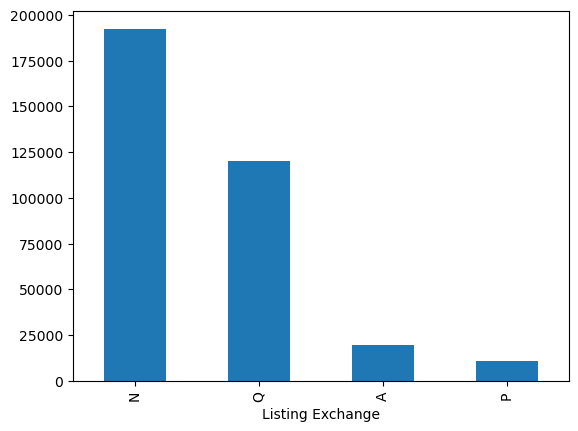

In [29]:
df['Listing Exchange'].value_counts().plot(kind = 'bar')

+ Use [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) to encode a categorical variable as numerical.
+ Important parameters:

    - `categories` allows you to specify the categories to work with.
    - `drop`: we can drop the `'first'` value (dummy encoding) or `'if_binary'`, a convenience setting for binary values.
    - `handle_unknown` allows three options, `'error'`, `'ignore'`, and `'infrequent_if_exist'`, depending on what we want to do with new values.

In [30]:
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder()
onehot.fit(df[['Listing Exchange']])

,categories,'auto'
,drop,None
,sparse_output,True
,dtype,<class 'numpy.float64'>
,handle_unknown,'error'
,min_frequency,None
,max_categories,None
,feature_name_combiner,'concat'


In [31]:
listing_enc = onehot.transform(df[['Listing Exchange']])
listing_enc.toarray()

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], shape=(343169, 4))

# Pipelines

+ It is impractical and costly to manipulate data "by hand". 
+ To manage data preprocessing steps within the cross-validation process use `Pipeline` objects.
+ A [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) object allows us to sequentially apply transformation steps and, if required, a predictor.
+ `Pipeline` objects compose transforms, i.e., classes that implement `transform` and `fit` methods.
+ The purpose of `Pipeline` objects is to ensemble transforms and predictors to be used in cross-validation.
+ A `Pipeline` is defined by a list of tuples.
+ Each tuple is composed of `("name", <ColumnTransformer>)`, the name of the step and the `<ColumnTransformer>` function of our chosing.

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, cohen_kappa_score, f1_score


In [33]:
pipe1 = Pipeline(
    [
        ('onehot', OneHotEncoder(handle_unknown='ignore')),
        ('knn', DecisionTreeClassifier(criterion = 'entropy', max_depth=3))

    ]
)
pipe1

,steps,"[('onehot', ...), ('knn', ...)]"
,transform_input,None
,memory,None
,verbose,False
,categories,'auto'
,drop,None
,sparse_output,True
,dtype,<class 'numpy.float64'>
,handle_unknown,'ignore'
,min_frequency,None
,max_categories,None


In [34]:
X0 = df[['Listing Exchange', 'Market Category']]
Y0 = df['target']
X0_train, X0_test, Y0_train, Y0_test = train_test_split(X0, Y0, test_size=0.2, random_state=42)

pipe1.fit(X0_train, Y0_train)

,steps,"[('onehot', ...), ('knn', ...)]"
,transform_input,None
,memory,None
,verbose,False
,categories,'auto'
,drop,None
,sparse_output,True
,dtype,<class 'numpy.float64'>
,handle_unknown,'ignore'
,min_frequency,None
,max_categories,None


In [35]:
Y_pred_train = pipe1.predict(X0_train)
Y_pred_test = pipe1.predict(X0_test)

In [36]:
Y_poba_train = pipe1.predict_proba(X0_train)
Y_proba_test = pipe1.predict_proba(X0_test)

In [37]:
res = {
    'accuracy_score_train': accuracy_score(Y0_train, Y_pred_train),
    'accuracy_score_test': accuracy_score(Y0_test, Y_pred_test),
    'cohen_kappa_train': cohen_kappa_score(Y0_train, Y_pred_train),
    'cohen_kappa_test': cohen_kappa_score(Y0_test, Y_pred_test),
    'log_loss_train': log_loss(Y0_train, Y_poba_train),
    'log_loss_test': log_loss(Y0_test, Y_proba_test),
    'f1_score_train': f1_score(Y0_train, Y_pred_train),
    'f1_score_test': f1_score(Y0_test, Y_pred_test)
}
res

{'accuracy_score_train': 0.5429653778206786,
 'accuracy_score_test': 0.542049130168721,
 'cohen_kappa_train': 0.0,
 'cohen_kappa_test': 0.0,
 'log_loss_train': 0.6886466167077266,
 'log_loss_test': 0.6886019437639563,
 'f1_score_train': 0.0,
 'f1_score_test': 0.0}

+ The model does not show great performance, but the pipeline shows results. 
+ Below, we expand the pipeline to include more variables, and further we will work with more robust model selection pipelines.

## ColumnTransformer

+ Use [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) to apply transformers to specific columns of a DataFrame.
+ In this case, we will scale numeric variables and apply one-hot encoding to categorical columns.

In [38]:
from sklearn.compose import ColumnTransformer

In [39]:
transformer = ColumnTransformer(
    transformers=[
        ('numeric_transfomer', StandardScaler(), ['returns', 'Volume', 'op_cl', 'hi_lo'] ),
        ('onehot', OneHotEncoder(handle_unknown='infrequent_if_exist'), ['Listing Exchange', 'Market Category']), 
    ], remainder='drop'
)

pipe = Pipeline(
    [
        ('preproc', transformer), 
        ('decisiontree', DecisionTreeClassifier(criterion = 'entropy', max_depth=3))
    ]
)

# Model Selection

The model selection process is an iterative process in which :

+ Select schema and load data.
+ Define a pipeline and its (hyper) parameters.

    - Use ColumnTransformers to transform numeric and cateogrical variables.
    - Hyperparameters can be defined independently of code. 

+ Implement a splitting strategy. 

    - Use [cross_validate]() to select several metrics and operational details.

+ Measure performance.

    - [Select metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)

+ Repeat

## Training, Validation, Testing Split

+ The first spliting strategy is to use a training, validation, and test set.
+ Training set will be used to fit the model.
+ Validation set is used to evaluate hyperparameter choice.
+ Testing set is used to evaluate performance on data the model has not yet seen.
+ In this case we want to compare two models: 

    - Decision Tree with 3 minumum samples per leaf.
    - Decision Tree with 10 minimum samples per leaf.

![](./images/03b_train_validate_test.png)

## Setting parameters in pipeline steps

+ One can obtain the parameters of a pipeline with `pipe.get_params()`.
+ We can set any parameter of a pipeline with `pipe.set_parames(**kwargs)`. 
+ The input `**kwargs` is a dictionary of the params to be modified. Params of the steps are labeled with the name of the step followed by `__` and the name of the parameter.

+ There are a few steps that we will repeat: 

    - Fit the candidate model on training data.
    - Predict on training and test data.
    - Compute training and test performance metrics.
    - Return.

+ We encapsulate this procedure in a function. 

In [40]:
def evaluate_model(clf, X_train, Y_train, X_test, Y_test):
    clf.fit(X_train, Y_train)
    Y_pred_train = clf.predict(X_train)
    Y_pred_test = clf.predict(X_test)
    Y_proba_train = clf.predict_proba(X_train)
    Y_proba_test = clf.predict_proba(X_test)
    performance_metrics = {
        'log_loss_train': log_loss(Y_train, Y_proba_train),
        'log_loss_test': log_loss(Y_test, Y_proba_test),
        'cohen_kappa_train': cohen_kappa_score(Y_train, Y_pred_train),
        'cohen_kappa_test': cohen_kappa_score(Y_test, Y_pred_test),
        'f1_score_train': f1_score(Y_train, Y_pred_train),
        'f1_score_test': f1_score(Y_test, Y_pred_test),
        'accuracy_score_train': accuracy_score(Y_train, Y_pred_train),
        'accuracy_score_test': accuracy_score(Y_test, Y_pred_test),
    }
    return performance_metrics

In [41]:
# Schema
X = df[['returns', 'op_cl', 'hi_lo', 'Volume', 'Listing Exchange', 'Market Category']]
Y = df['target']

# Split the data
X_rest, X_test, Y_rest, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_validate, Y_train,  Y_validate = train_test_split(X_rest, Y_rest, test_size=0.2, random_state=42)


In [42]:
# Evaluate hyperparameter configuration 2
pipe_d3 = pipe.set_params(**{'decisiontree__max_depth': 3})
res_d3 = evaluate_model(pipe_d3, X_train, Y_train, X_validate, Y_validate)
res_d3

{'log_loss_train': 0.6804267782409581,
 'log_loss_test': 0.6801576174584758,
 'cohen_kappa_train': 0.0795307810051138,
 'cohen_kappa_test': 0.0754207945062152,
 'f1_score_train': 0.49518624930692073,
 'f1_score_test': 0.49325998911926494,
 'accuracy_score_train': 0.5440016755604932,
 'accuracy_score_test': 0.541970969093194}

In [43]:
# Evaluate hyperparameter configuration 2
pipe_d15 = pipe.set_params(**{'decisiontree__max_depth':15})
res_d15 = evaluate_model(pipe_d15, X_train, Y_train, X_validate, Y_validate)
res_d15

{'log_loss_train': 0.6409774616155887,
 'log_loss_test': 1.3244164028004382,
 'cohen_kappa_train': 0.14372413266371797,
 'cohen_kappa_test': 0.06264371402112712,
 'f1_score_train': 0.49625591171833944,
 'f1_score_test': 0.4491350996277644,
 'accuracy_score_train': 0.5809823884022074,
 'accuracy_score_test': 0.5418070555666855}

## Cross-Validation

+ Cross-validation is a resampling method.
+ It is an iterative method applied to training data.
+ Training data is divided into folds.
+ Each fold is used once as a validation set and the rest of the folds are used for training.
+ Test data is used for final evaluation.

From [Scikit's Documentation ](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-evaluating-estimator-performance), the diagram below shows the data divisions and folds during the cross-validation process.

![](./images/03b_grid_search_cross_validation.png)

There are two functions that can be used for [calculating cross-validation performance scores](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-evaluating-estimator-performance): `cross_val_score()` and `cross_validate()`. The first function, [`cross_val_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score), is a convenience function to get quick perfromance calculations. We will discuss `cross_validate()` as it offers advantages over `cross_val_score()`.

## Obtaining metrics

+ Use [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate) to measure one or more performance metrics and operational details.
+ There are two advantages of using this function. From [Scikit's documentation](https://scikit-learn.org/stable/modules/cross_validation.html#the-cross-validate-function-and-multiple-metric-evaluation):

>- It allows specifying multiple metrics for evaluation.
>- It returns a dict containing fit-times, score-times (and optionally training scores, fitted estimators, train-test split indices) in addition to the test score.


In [44]:
from sklearn.model_selection import cross_validate
scoring = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc', 'neg_log_loss', 'neg_brier_score']
d3_dict = cross_validate(pipe_d3, X, Y, cv=5, scoring = scoring, return_train_score = True)

In DataFrame form:

In [45]:
pd.DataFrame(d3_dict)

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_precision,train_precision,test_recall,train_recall,test_roc_auc,train_roc_auc,test_neg_log_loss,train_neg_log_loss,test_neg_brier_score,train_neg_brier_score
0,3.149804,0.217545,0.534414,0.580097,0.376549,0.489365,0.485535,0.551107,0.307521,0.440063,0.546882,0.625165,-1.684169,-0.643915,-0.260973,-0.229832
1,2.976845,0.232729,0.524871,0.580698,0.442907,0.516025,0.477371,0.546333,0.413084,0.488902,0.528640,0.626022,-1.725527,-0.642771,-0.265480,-0.229386
2,2.821363,0.174644,0.528965,0.579482,0.517427,0.523492,0.486690,0.543146,0.552309,0.505210,0.534960,0.626747,-1.615211,-0.640747,-0.264236,-0.228700
3,2.751877,0.168175,0.513783,0.592602,0.451901,0.515342,0.466276,0.564974,0.438386,0.473726,0.513921,0.645401,-2.195834,-0.631880,-0.275124,-0.225173
4,2.795078,0.147723,0.535180,0.575841,0.363767,0.442055,0.486089,0.554554,0.290631,0.367502,0.556171,0.618649,-2.073197,-0.645430,-0.263915,-0.230698


In [46]:
d15_dict = cross_validate(pipe_d15, X, Y, cv=5, scoring = scoring, return_train_score = True)
pd.DataFrame(d15_dict)

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_precision,train_precision,test_recall,train_recall,test_roc_auc,train_roc_auc,test_neg_log_loss,train_neg_log_loss,test_neg_brier_score,train_neg_brier_score
0,2.871808,0.205598,0.534240,0.580086,0.376315,0.489408,0.485233,0.551079,0.307330,0.440150,0.546688,0.625180,-1.687034,-0.643914,-0.261140,-0.229831
1,3.601056,0.183778,0.524827,0.580647,0.443284,0.516076,0.477353,0.546249,0.413754,0.489062,0.528746,0.625950,-1.726697,-0.642814,-0.265400,-0.229402
2,2.894652,0.170373,0.528892,0.579493,0.517115,0.523427,0.486607,0.543173,0.551703,0.505067,0.534713,0.626791,-1.621884,-0.640682,-0.264376,-0.228682
3,2.771091,0.175598,0.513871,0.592679,0.452503,0.515006,0.466441,0.565200,0.439374,0.473001,0.514240,0.645543,-2.192503,-0.631766,-0.275129,-0.225129
4,2.882396,0.171875,0.535122,0.575808,0.363052,0.442025,0.485945,0.554496,0.289771,0.367486,0.556011,0.618589,-2.070378,-0.645505,-0.263944,-0.230718


# About Performance

+ Notice that in order to acquire information about our model and continue development, we are spending resources: time, electricity, equipment use, etc. As well, we are generating data and binary objects that implement our models (fitted `Pipeline` objects, for example).
+ For certain applications, operating performance (latency or `'score_time'`) may be as important or more important than predictive performance metrics. 
+ Every experiment throws important information and we can log them, as well as run them systematically.

In [47]:
pd.DataFrame(d15_dict).mean()

fit_time                 3.004201
score_time               0.181444
test_accuracy            0.527390
train_accuracy           0.581743
test_f1                  0.430454
train_f1                 0.497189
test_precision           0.480316
train_precision          0.552040
test_recall              0.400386
train_recall             0.454953
test_roc_auc             0.536080
train_roc_auc            0.628411
test_neg_log_loss       -1.859699
train_neg_log_loss      -0.640936
test_neg_brier_score    -0.265998
train_neg_brier_score   -0.228753
dtype: float64